In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

ADD data preprocessing
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  frequency  heightTB  heightB  heightM
type 6367    m      2.97    111.22      0.02        400        30       15        2
     6368    m      2.96    115.43      0.02        400        30       15        2
     6369    m      2.96    111.62      0.02        400        30       15        2
     6370    m      2.95    108.95      0.02        400        30       15        2
     6371    m      2.94    103.93      0.02        400        30       15        2
Combined data set: (31188, 8)
type filterin

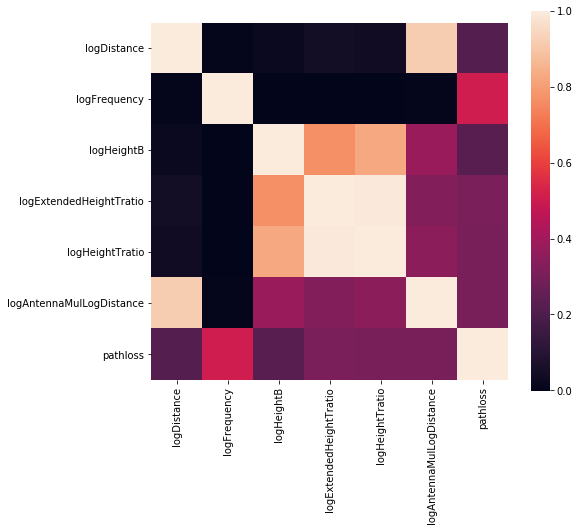

In [2]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [3]:
%autoreload
samplingRatio = 0.7
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

normalizer = 'manual'

X, scaler = normalizeData(addDataSample[xCols], scaler = normalizer)
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance  pathloss
count     79125.00      79125.00    79125.00    79125.00                 79125.00         79125.00                  79125.00  79125.00
mean          0.31          3.03        1.05        0.30                    -0.40            -0.32                      0.32    127.47
std           0.12          0.32        0.16        0.00                     0.26             0.33                      0.14     16.61
min           0.00          2.60        0.85        0.30                    -0.95            -1.00                      0.00     85.06
25%           0.23          2.60        0.85        0.30                    -0.62            -0.62                      0.24    114.91
50%           0.33          3.15        1.18        0.30                    -0.39            -0.27                      0.33    127.17
75%           0.40          3

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


normalization distribution(after):
       logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     55388.00      55388.00    55388.00    55388.00                 55388.00         55388.00                  55388.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.32
std           0.12          0.03        0.02        0.00                     0.26             0.33                      0.14
min           0.00          0.26        0.08        0.30                    -0.95            -1.00                      0.00
25%           0.23          0.26        0.08        0.30                    -0.62            -0.63                      0.24
50%           0.33          0.31        0.12        0.30                    -0.39            -0.27                      0.33
75%           0.40          0.34        0.12        0.30                    -0.19         

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1
trainErrSum, testErrSum = 0, 0
model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    

    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    i+=1

filename = 'model/ann_manual.sav'
pickle.dump(model, open(filename, 'wb'))

i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:11.175914078908338 / test:11.373380897397857
#2 Error(RMSE)-train:10.997813909275514 / test:10.98598297341641
#3 Error(RMSE)-train:10.974495300584055 / test:10.930737793226182
#4 Error(RMSE)-train:10.95443439236205 / test:11.003711066526227
#5 Error(RMSE)-train:10.903103557087054 / test:10.965022424359578

Average train error:11.00 | Average test error:11.05


In [5]:
X_testSet, Y_testSet = np.zeros((1,7)), np.zeros((1,))
for X_train, y_train, X_test,y_test, trainError, testError in dataSet:
    X_testSet = np.concatenate((X_testSet, X_test), axis=0)
    Y_testSet = np.concatenate((Y_testSet, y_test), axis=0)

X_testSet = np.delete(X_testSet, 0, 0)
Y_testSet = np.delete(Y_testSet, 0, 0)

Group-  0.26Ghz Data shape:(18378, 8)
Group-  0.31Ghz Data shape:(18684, 8)
Group-  0.34Ghz Data shape:(18326, 8)


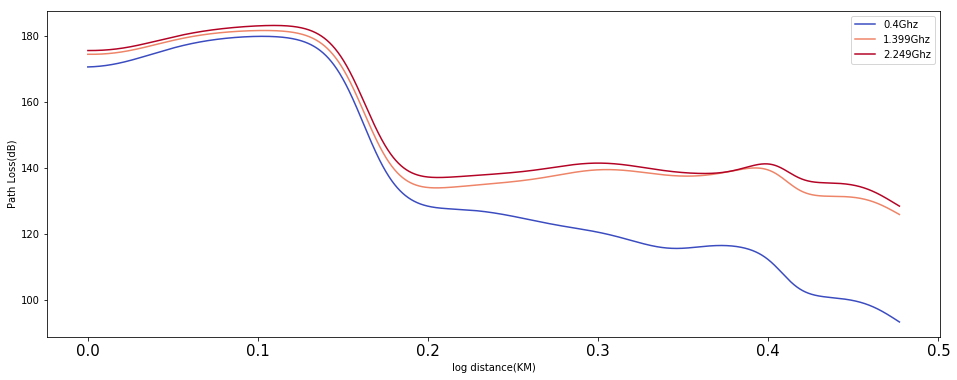

In [15]:
%autoreload
i = 1
model = pickle.load(open("model/ann_manual.sav", 'rb'))

data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_testSet, columns=xCols),
                     pd.DataFrame(Y_testSet, columns=['pathloss']), ['logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'])

graphX = data[0]
graphY = data[1]
train_2d_graph(model, graphX, graphY, 'logDistance', "log distance(KM)")

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

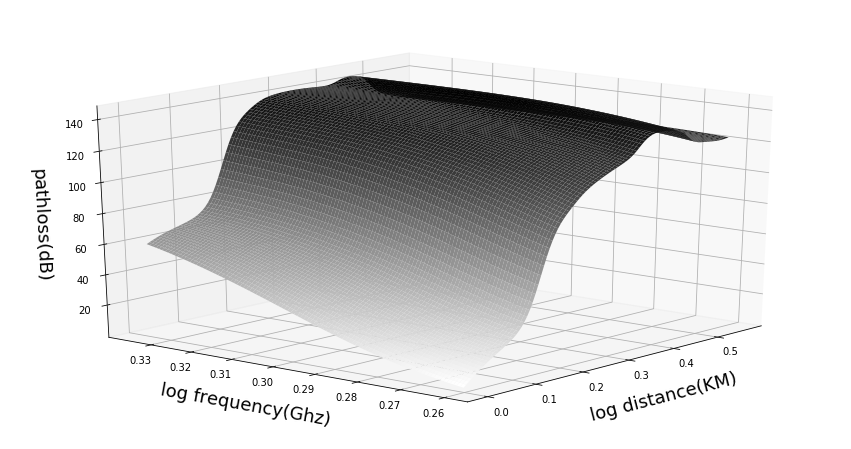

In [7]:
%autoreload
i = 1
model = pickle.load(open("model/ann_manual.sav", 'rb'))

print("3D graph for log distance and log frequency - trainset #{}".format(i))
targetCols = ['logAntennaMulLogDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X_testSet, columns=xCols),
                     pd.DataFrame(Y_testSet, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

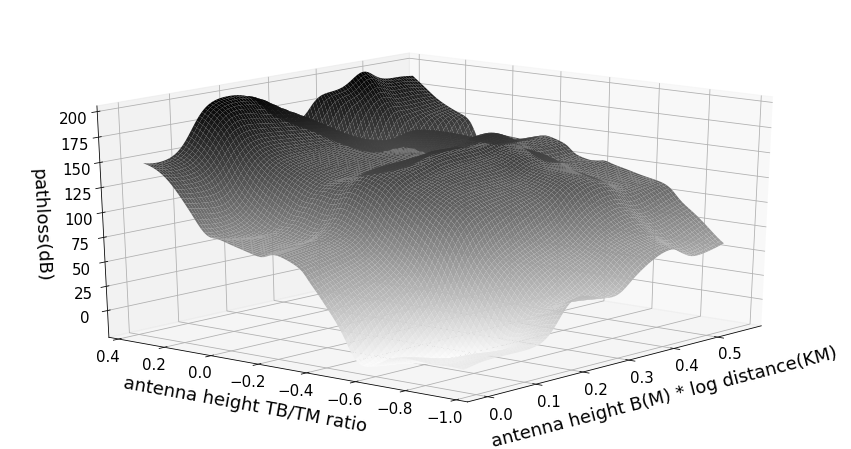

In [8]:
%autoreload
i = 1
model = pickle.load(open("model/ann_manual.sav", 'rb'))

print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
varX = ['logAntennaMulLogDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X_testSet, columns=xCols),
                     pd.DataFrame(Y_testSet, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)


3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

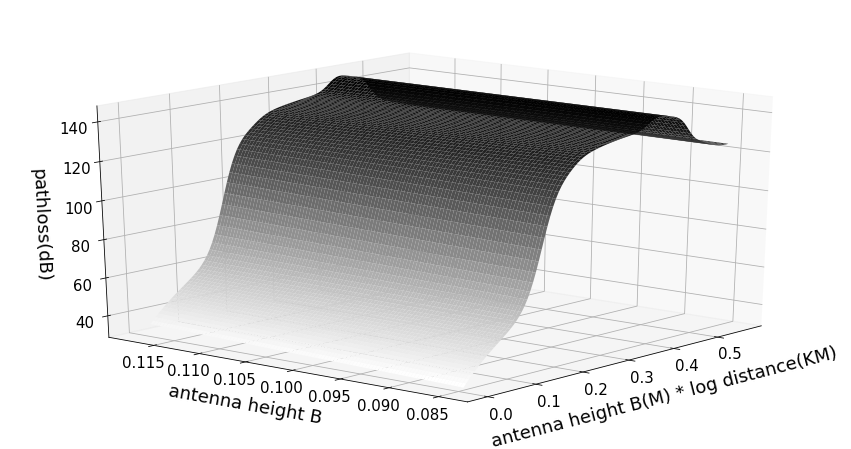

In [9]:
%autoreload
i = 1
model = pickle.load(open("model/ann_manual.sav", 'rb'))

print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logAntennaMulLogDistance', 'logHeightB']
xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X_testSet, columns=xCols),
                     pd.DataFrame(Y_testSet, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)

In [10]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0

linearModel = Ridge(alpha=0.0001)
ANNmodel = pickle.load(open("model/ann_manual.sav", 'rb'))

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("Equation Derivation for trainset #{}".format(i))

    ANNPred = ANNmodel.predict(X_train)
    
    linearModel.fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(trainError, testError))
    print("Linear-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(RMSE_LIN_TRAIN,RMSE_LIN_TEST))
    print("ANN-Linear-Error(RMSE):", RMSE_LIN_ANN)    

    print("\nObjective Function")
    print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[6],linearModel.coef_[1]*10,\
              linearModel.coef_[2]*10,linearModel.coef_[3],linearModel.coef_[4], linearModel.coef_[5], linearModel.intercept_)) 

Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train: 11.18/test: 11.37
Linear-Error(RMSE)-1-train: 12.71/test: 12.84
ANN-Linear-Error(RMSE): 6.618367249751472

Objective Function
L_pathloss = (-87.66 + 110.89log_hb)log_d + 2664.73log_f + 1410.61log_hb +  -0.00log_hm + 167.60log_(h_tb + h_b/h_tm + h_m) + -137.26log_(h_tb/h_tm) +  46.20
Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train: 11.00/test: 10.99
Linear-Error(RMSE)-1-train: 12.74/test: 12.72
ANN-Linear-Error(RMSE): 6.625272897985944

Objective Function
L_pathloss = (-87.03 + 110.35log_hb)log_d + 2663.73log_f + 1582.89log_hb +  -0.00log_hm + 172.69log_(h_tb + h_b/h_tm + h_m) + -141.95log_(h_tb/h_tm) +  44.93
Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train: 10.97/test: 10.93
Linear-Error(RMSE)-1-train: 12.74/test: 12.73
ANN-Linear-Error(RMSE): 6.63075629380751

Objective Function
L_pathloss = (-83.57 + 107.33log_hb)log_d + 2654.17log_f + 1869.16log_hb +  -0.00log_hm + 179.18log_(h_tb + h_b/h_tm + h_m) 